In [3]:
import torch
import faiss 
import numpy as np
from scipy.io import mmread
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import random

In [4]:
#check cuda 
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Compute Capability: {torch.cuda.get_device_capability(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9} GB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0) / 1e9} GB")
else:
    print("No CUDA-compatible GPU found.")

torch.cuda.empty_cache()

CUDA Device Count: 1
Device Name: NVIDIA GeForce RTX 2060
Compute Capability: (7, 5)
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


In [5]:
rawData = mmread('scRNA.mtx')
coo_matrix = rawData.tocoo()
print(coo_matrix)
print(coo_matrix.shape)

<COOrdinate sparse matrix of dtype 'float64'
	with 86422438 stored elements and shape (34619, 27180)>
  Coords	Values
  (30, 0)	878.85046
  (44, 0)	2636.5513
  (58, 0)	878.85046
  (74, 0)	878.85046
  (77, 0)	878.85046
  (109, 0)	878.85046
  (225, 0)	3515.4019
  (247, 0)	878.85046
  (272, 0)	878.85046
  (273, 0)	1318.2756
  (365, 0)	878.85046
  (366, 0)	2636.5513
  (421, 0)	878.85046
  (431, 0)	1757.7009
  (440, 0)	878.85046
  (442, 0)	5273.1025
  (499, 0)	16698.158
  (594, 0)	878.85046
  (649, 0)	1757.7009
  (688, 0)	878.85046
  (706, 0)	878.85046
  (831, 0)	1757.7009
  (835, 0)	2636.5513
  (867, 0)	878.85046
  (911, 0)	2636.5513
  :	:
  (32162, 27179)	142.14685
  (32202, 27179)	88.841736
  (32298, 27179)	177.68347
  (32423, 27179)	59.227825
  (32425, 27179)	177.68347
  (32564, 27179)	88.841736
  (33015, 27179)	177.68347
  (33454, 27179)	177.68347
  (33504, 27179)	177.68347
  (33538, 27179)	177.68347
  (33578, 27179)	88.841736
  (33636, 27179)	177.68347
  (33647, 27179)	284.01257
  (33

##### Process And Modify Data

In [6]:
def clean_and_split_data(coo_matrix, max_number):
    #get only non-zero values
    total_nnz = coo_matrix.nnz 

    # Ensure max_nnz doesn’t exceed total
    if max_number >= total_nnz:
        raise ValueError(f"max_nnz ({max_number}) must be less than total non-zero elements ({total_nnz})")
    
    rows = coo_matrix.row
    cols = coo_matrix.col
    data = coo_matrix.data
    
    selected_indices = np.arange(max_number)  

    selected = coo_matrix.__class__(
        (data[selected_indices], (rows[selected_indices], cols[selected_indices])),
        shape=coo_matrix.shape
    )
    
    return selected

processed_data = clean_and_split_data(coo_matrix=coo_matrix, max_number=900000)
print(processed_data)

<COOrdinate sparse matrix of dtype 'float64'
	with 900000 stored elements and shape (34619, 27180)>
  Coords	Values
  (30, 0)	878.85046
  (44, 0)	2636.5513
  (58, 0)	878.85046
  (74, 0)	878.85046
  (77, 0)	878.85046
  (109, 0)	878.85046
  (225, 0)	3515.4019
  (247, 0)	878.85046
  (272, 0)	878.85046
  (273, 0)	1318.2756
  (365, 0)	878.85046
  (366, 0)	2636.5513
  (421, 0)	878.85046
  (431, 0)	1757.7009
  (440, 0)	878.85046
  (442, 0)	5273.1025
  (499, 0)	16698.158
  (594, 0)	878.85046
  (649, 0)	1757.7009
  (688, 0)	878.85046
  (706, 0)	878.85046
  (831, 0)	1757.7009
  (835, 0)	2636.5513
  (867, 0)	878.85046
  (911, 0)	2636.5513
  :	:
  (14359, 264)	241.19199
  (14367, 264)	96.47679
  (14368, 264)	24.119198
  (14369, 264)	24.119198
  (14374, 264)	48.238396
  (14376, 264)	120.59599
  (14379, 264)	96.47679
  (14382, 264)	24.119198
  (14383, 264)	48.238396
  (14402, 264)	24.119198
  (14403, 264)	24.119198
  (14410, 264)	120.59599
  (14412, 264)	48.238396
  (14414, 264)	48.238396
  (14417, 

##### Graph Data Object

In [7]:
def cell_graph(data, threshold):

    gene_expression = data.data
    
    x = np.asarray(gene_expression, dtype=np.float32)
    x = x.reshape(-1, 1)


    gpu_resource_manager = faiss.StandardGpuResources() 
    similarity_object = faiss.IndexFlatL2(1)
    similarity_object_in_gpu = faiss.index_cpu_to_gpu(gpu_resource_manager, 0, similarity_object)


    print(similarity_object_in_gpu.is_trained)  
    print(f"FAISS index type: {type(similarity_object_in_gpu)}") 


    similarity_object_in_gpu.add(x)
    k=2
    distances, indices = similarity_object_in_gpu.search(x, k + 1)
    
    edge_index_list = []
    outliers = []
    
    for i in range(len(gene_expression)):
        nearest_neighbors = indices[i, 1:k+1]  
        neighbor_distances = distances[i, 1:k+1]
        
        for j, dist in zip(nearest_neighbors, neighbor_distances):
            if dist <= threshold ** 2:
                edge_index_list.append((i, j))
            else:
                outliers.append(int(j))
    

    edge_index_np = np.array(edge_index_list).T
    edge_index = torch.tensor(edge_index_np, dtype=torch.long) if edge_index_np.size > 0 else torch.empty((2, 0), dtype=torch.long)

    cleaned_outliers = list(set(outliers))
    print(cleaned_outliers)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    pyg_data = Data(edge_index=edge_index, x=x_tensor)
    print(pyg_data)
    return pyg_data

data = cell_graph(data=processed_data,threshold=500)

True
FAISS index type: <class 'faiss.swigfaiss.GpuIndexFlat'>
[397700, 696586, 223116, 163986, 823956, 4763, 490399, 333091, 177955, 747556, 284331, 157360, 283697, 24500, 340662, 703416, 845753, 223163, 372669, 774463, 395840, 538689, 744770, 291661, 217679, 341846, 617691, 507749, 507750, 744808, 877161, 696554, 321899, 75244, 642539, 552686, 659695, 800882]
Data(x=[900000, 1], edge_index=[2, 1799946])


In [8]:
gene_expression_lvl = data.x.cpu().numpy()

k = 10  
d = gene_expression_lvl.shape[1] 
kmeans = faiss.Kmeans(d, k, niter=300, gpu=True)  


kmeans.train(gene_expression_lvl)

_, labels = kmeans.index.search(gene_expression_lvl, 1) 
labels = labels.flatten()

In [9]:
cluster_counts = np.bincount(labels)  


for i in range(k):
    print(f"Cluster {i}: {cluster_counts[i]} nodes")

Cluster 0: 48621 nodes
Cluster 1: 12918 nodes
Cluster 2: 107 nodes
Cluster 3: 449048 nodes
Cluster 4: 244973 nodes
Cluster 5: 9693 nodes
Cluster 6: 30186 nodes
Cluster 7: 5867 nodes
Cluster 8: 1493 nodes
Cluster 9: 97094 nodes


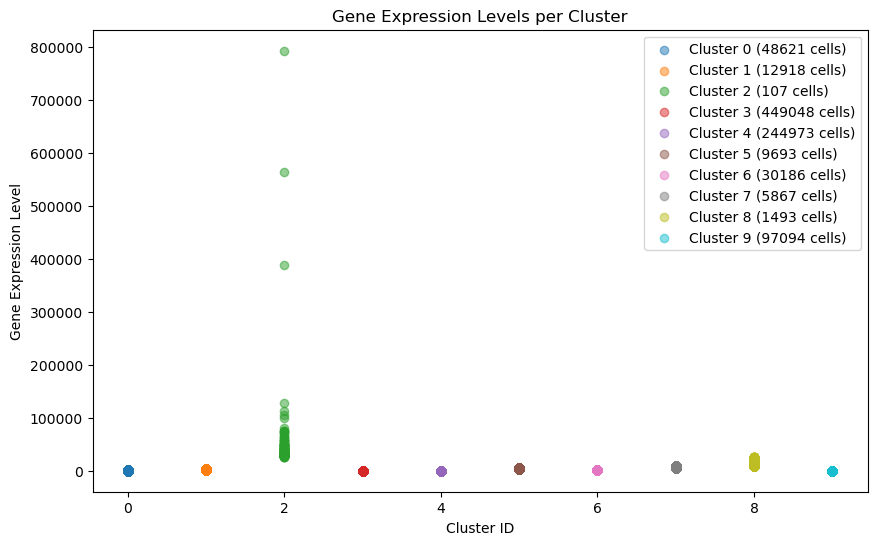

In [10]:
gene_expression_levels = data.x.cpu().numpy().flatten() 

plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels)


for label in unique_labels:
    cluster_cells = gene_expression_lvl[labels == label]
    num_cells = len(cluster_cells)
    plt.scatter(np.full_like(cluster_cells, label), cluster_cells, alpha=0.5, label=f'Cluster {label} ({num_cells} cells)')

# Label the axes
plt.xlabel('Cluster ID')
plt.ylabel('Gene Expression Level')
plt.title('Gene Expression Levels per Cluster')


plt.legend()
plt.show()

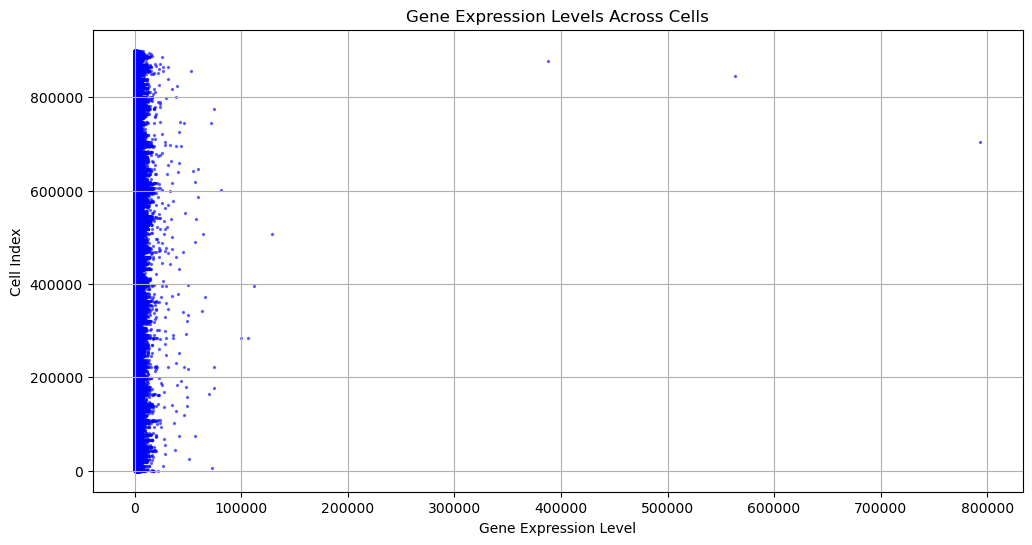

In [19]:
gene_expression_levels_cpu = gene_expression_levels.cpu().numpy() if hasattr(gene_expression_levels, "cpu") else gene_expression_levels
num_cells = len(gene_expression_levels_cpu)

cell_indices = np.arange(num_cells)

plt.figure(figsize=(12, 6))
plt.scatter(gene_expression_levels_cpu, cell_indices, alpha=0.5, s=2, c='blue')  

plt.xlabel('Gene Expression Level')
plt.ylabel('Cell Index')
plt.title('Gene Expression Levels Across Cells')
plt.grid(True)
plt.show()

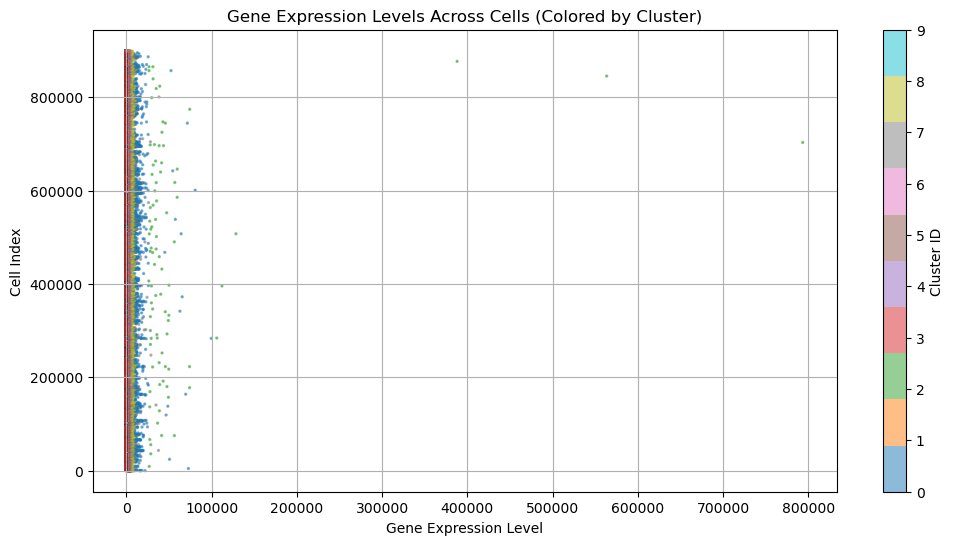

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(gene_expression_levels_cpu, cell_indices, c=labels, cmap='tab10', alpha=0.5, s=2)
plt.xlabel('Gene Expression Level')
plt.ylabel('Cell Index')
plt.title('Gene Expression Levels Across Cells (Colored by Cluster)')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()

Graph Neural Network

In [22]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))  
        
        for _ in range(num_layers - 2):  
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        self.convs.append(SAGEConv(hidden_channels, out_channels))  

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]: 
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index) 
        return x  

Traning Without Loss Function

In [23]:
#train without loss function
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

model = GraphSAGE(in_channels=1, hidden_channels=128, out_channels=64, num_layers=2).to(device)
model2 = GraphSAGE(in_channels=1, hidden_channels=64,out_channels=64, num_layers=4).to(device)
data = data.to(device)

model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

print(embeddings.shape)

torch.Size([900000, 64])


In [24]:
embeddings_np = embeddings.cpu().numpy()

d = embeddings_np.shape[1]  
k = 10
kmeans = faiss.Kmeans(d, k, niter=300, gpu=True)  


kmeans.train(embeddings_np)
_, labels = kmeans.index.search(embeddings_np, 1)


labels = torch.tensor(labels.flatten(), device='cuda')
print(labels.shape)

torch.Size([900000])


In [25]:
cluster_counts = torch.bincount(labels)

# Print the number of cells in each cluster
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count.item()} cells")

Cluster 0: 1248 cells
Cluster 1: 8503 cells
Cluster 2: 86 cells
Cluster 3: 708933 cells
Cluster 4: 6375 cells
Cluster 5: 7493 cells
Cluster 6: 33653 cells
Cluster 7: 3781 cells
Cluster 8: 4108 cells
Cluster 9: 125820 cells


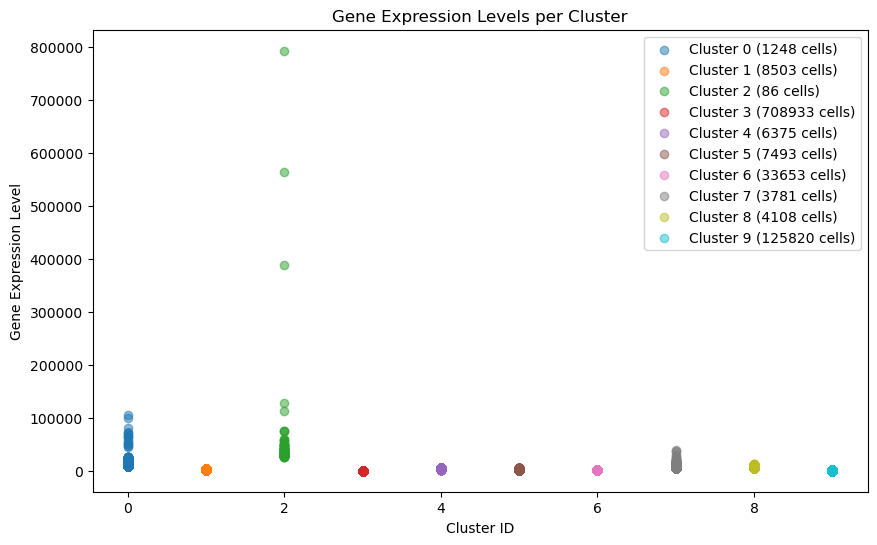

In [26]:
labels_cpu = labels.cpu().numpy()
gene_expression_levels_cpu = gene_expression_levels


plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels_cpu)

for label in unique_labels:
    cluster_cells = gene_expression_levels_cpu[labels_cpu == label]
    num_cells = len(cluster_cells)
    plt.scatter(np.full_like(cluster_cells, label), cluster_cells, alpha=0.5, label=f'Cluster {label} ({num_cells} cells)')


plt.xlabel('Cluster ID')
plt.ylabel('Gene Expression Level')
plt.title('Gene Expression Levels per Cluster')
plt.legend()
plt.show()


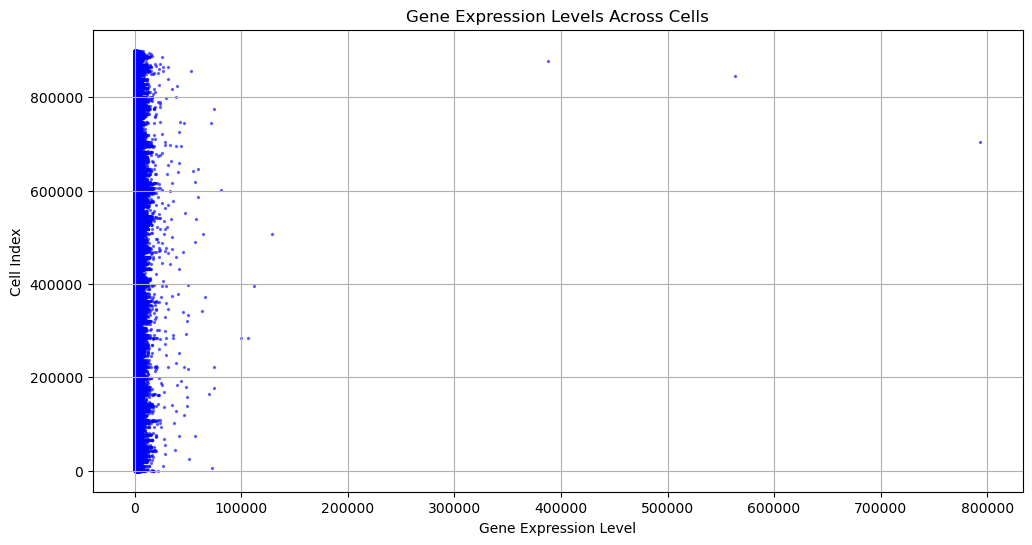

In [27]:
gene_expression_levels_cpu = gene_expression_levels.cpu().numpy() if hasattr(gene_expression_levels, "cpu") else gene_expression_levels
num_cells = len(gene_expression_levels_cpu)

cell_indices = np.arange(num_cells)

plt.figure(figsize=(12, 6))
plt.scatter(gene_expression_levels_cpu, cell_indices, alpha=0.5, s=2, c='blue')  

plt.xlabel('Gene Expression Level')
plt.ylabel('Cell Index')
plt.title('Gene Expression Levels Across Cells')
plt.grid(True)
plt.show()

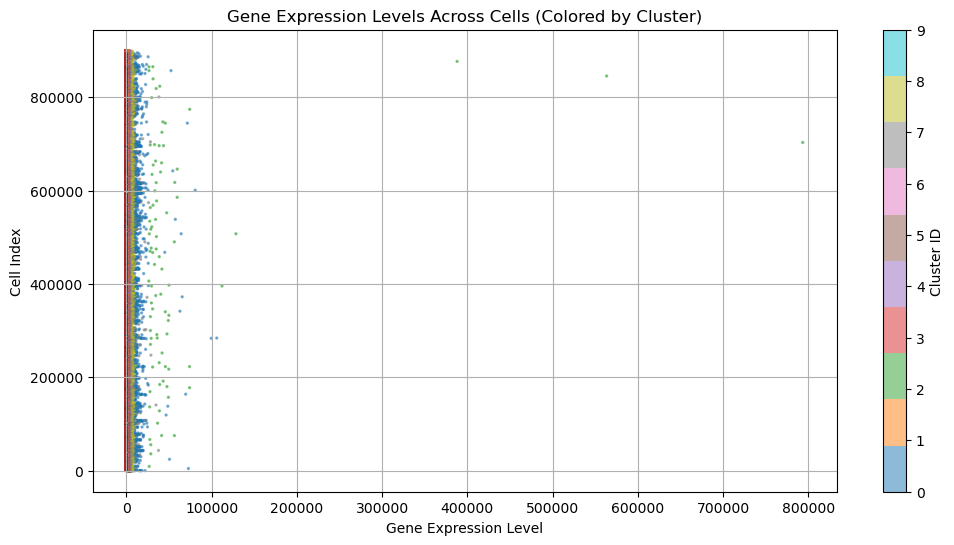

In [28]:
plt.figure(figsize=(12, 6))
plt.scatter(gene_expression_levels_cpu, cell_indices, c=labels_cpu, cmap='tab10', alpha=0.5, s=2)
plt.xlabel('Gene Expression Level')
plt.ylabel('Cell Index')
plt.title('Gene Expression Levels Across Cells (Colored by Cluster)')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()

In [29]:
def constrastive_loss(z_i, z_j, y, margin=1.0):
    z_i_np = z_i.detach().cpu().numpy().astype('float32')
    z_j_np = z_j.detach().cpu().numpy().astype('float32')

   
    index = faiss.IndexFlatL2(z_i.shape[1])
    if torch.cuda.is_available():
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    index.add(z_j_np)
    distances, _ = index.search(z_i_np, 1)

    distances = torch.tensor(distances, dtype=torch.float32, device=z_i.device).squeeze(1)

    positive_loss = y * distances.pow(2)
    negative_loss = (1 - y) * F.relu(margin - distances).pow(2)
    return (positive_loss + negative_loss).mean()

In [30]:
def generate_pairs_with_faiss_gpu(embeddings, k=5, num_negative=5):

    device = embeddings.device
    emb_np = embeddings.detach().cpu().numpy().astype('float32')
    num_nodes = emb_np.shape[0]

    index = faiss.IndexFlatL2(emb_np.shape[1])
    if torch.cuda.is_available():
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)
    index.add(emb_np)

    _, neighbors = index.search(emb_np, k + 1)

    pos_i, pos_j, neg_i, neg_j = [], [], [], []
    for i in range(num_nodes):
        for j in neighbors[i][1:]:  # Skip self
            pos_i.append(i)
            pos_j.append(j)
        for _ in range(num_negative):
            j = random.randint(0, num_nodes - 1)
            while j in neighbors[i]:
                j = random.randint(0, num_nodes - 1)
            neg_i.append(i)
            neg_j.append(j)

    z_i = torch.cat([embeddings[pos_i], embeddings[neg_i]], dim=0).to(device)
    z_j = torch.cat([embeddings[pos_j], embeddings[neg_j]], dim=0).to(device)
    y = torch.cat([
        torch.ones(len(pos_i)),
        torch.zeros(len(neg_i))
    ], dim=0).to(device)

    return z_i, z_j, y  